In [2]:
import requests as rqs
import networkx as nx 
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
import csv
from fuzzywuzzy import fuzz
import powerlaw as plw
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, lognorm, powerlaw
from scipy.optimize import curve_fit
from matplotlib.ticker import LogFormatterMathtext
from collections import Counter
import heapq
import json
from pprint import pprint
import regex as r

c:\Users\nicco\OneDrive\Desktop\DHDK\2ndYear\courses\NA\foggedaboutit\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


     ID                                            Domande      Risposte
7     1  Benvenuto.Per compilare questa semplice indagi...           N/A
30   27  To begin, pleaseenter your Amazon Mechanical T...           N/A
22   28  Note that your WorkerID can be found on your d...           N/A
28  884  Thanks for your participation! Please answer t...  Male, Female
1   885                                               Age:           N/A


In [14]:
def cid_to_name(cid):
    pattern = r"CID0+(\d+)"
    norm_cid = re.search(pattern, cid).group(1)

    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{norm_cid}/property/Title/TXT"
    response = rqs.get(url)

    if response.status_code == 200:
        return response.text.strip()
    else:
        return "i'm not popping this shit bruh"

In [ ]:
print(cid_to_name("CID00002173"))

6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylate


In [3]:
def name_to_cid(drug_name):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/cids/TXT"
    
    response = rqs.get(url)
    
    if response.status_code == 200:
        cid = response.text.strip()
        n_zeros = 12 - len(cid) - 3
        return f"CID{''.join(['0' for n in range(n_zeros)])}{cid}"
    else:
        return f"Skibidi status - {response.status_code}: {drug_name} got no rizz fr fr"

In [ ]:
print(name_to_cid("Aspirin"))

CID000002244


In [ ]:
print(cid_to_name(name_to_cid("Aspirin")))

Aspirin


In [8]:
drugs_nw = pd.read_csv("./ChChse-Decagon_polypharmacy.csv")
drugs_nw.head(5)

,# STITCH 1,STITCH 2,Polypharmacy Side Effect,Side Effect Name
0,CID000002173,CID000003345,C0151714,hypermagnesemia
1,CID000002173,CID000003345,C0035344,retinopathy of prematurity
2,CID000002173,CID000003345,C0004144,atelectasis
3,CID000002173,CID000003345,C0002063,alkalosis
4,CID000002173,CID000003345,C0004604,Back Ache


In [3]:
rank_drugs = pd.read_csv("./top_300_drugs.csv")
rank_drugs.head(5)

,Rank,Drug Name,Total Prescriptions (2022),Total Patients (2022),Annual Change
0,1,Atorvastatin,"109,582,746","27,935,702",0
1,2,Metformin,"86,747,907","19,536,027",0
2,3,Lisinopril,"82,513,967","20,314,304",1
3,4,Levothyroxine,"82,431,914","18,130,331",1
4,5,Amlodipine,"70,766,211","17,789,649",0


In [ ]:
drugs_in_nw = drugs_nw["# STITCH 1"].unique().tolist()  
drugs_in_nw += drugs_nw["STITCH 2"].unique().tolist()
drugs_in_nw = list(set(drugs_in_nw))

print(drugs_in_nw)
print(len(drugs_in_nw))


['CID000004894', 'CID000060815', 'CID000003780', 'CID000004205', 'CID000002477', 'CID000002673', 'CID000005297', 'CID000443871', 'CID000003148', 'CID000003016', 'CID000004499', 'CID000004158', 'CID000060164', 'CID000000598', 'CID000005039', 'CID000154059', 'CID000003821', 'CID000005584', 'CID000005372', 'CID000002973', 'CID000002232', 'CID000005734', 'CID000003488', 'CID000002732', 'CID000148211', 'CID000004539', 'CID000003403', 'CID000006691', 'CID000005505', 'CID000005035', 'CID000003440', 'CID000005426', 'CID000002141', 'CID000003750', 'CID000002708', 'CID005282226', 'CID000213039', 'CID000003675', 'CID000003249', 'CID000002249', 'CID000004513', 'CID000004595', 'CID000001690', 'CID000027686', 'CID000002676', 'CID000003261', 'CID000002349', 'CID000004543', 'CID000005376', 'CID000005002', 'CID000005029', 'CID000003642', 'CID000005454', 'CID000104741', 'CID000004449', 'CID000003957', 'CID000005195', 'CID000000853', 'CID000003958', 'CID000002662', 'CID000005726', 'CID000004946', 'CID000

In [12]:
drugs_present_in_both = []

In [ ]:
for idx, row in rank_drugs.iterrows():
    drug = row["Drug Name"]
    rank = row["Rank"]
    if name_to_cid(drug) in drugs_in_nw:
        drugs_present_in_both.append([rank, drug])

ranked_drugs_in_nw = pd.DataFrame(drugs_present_in_both,columns=["Rank", "Drug Name"])

In [16]:
print(ranked_drugs_in_nw)

     Rank            Drug Name
0       2            Metformin
1       5           Amlodipine
2       6           Metoprolol
3       7            Albuterol
4       8             Losartan
..    ...                  ...
100   270         Fluorouracil
101   276  Medroxyprogesterone
102   291     Chlorpheniramine
103   295          Guaifenesin
104   298              Azelate

[105 rows x 2 columns]


In [17]:
ranked_drugs_in_nw.to_csv("./ranked_drugs_matching.csv")

In [ ]:
side_effects_df = pd.DataFrame(drugs_nw["Side Effect Name"].unique(), columns=["Side effect"])
print(side_effects_df)

                        Side effect
0                   hypermagnesemia
1        retinopathy of prematurity
2                       atelectasis
3                         alkalosis
4                         Back Ache
...                             ...
1312                       splinter
1313  hypogonadotropic hypogonadism
1314                       chloasma
1315           estrogen replacement
1316                         rabies

[1317 rows x 1 columns]


In [21]:
side_effects_df.to_csv("./all_side_effects.csv")

In [ ]:


model = SentenceTransformer('all-MiniLM-L6-v2')

df1 = pd.read_csv("./all_side_effects.csv")["0"].tolist()
df2 = pd.read_csv("./ranking.csv")["Name"].tolist()

embeddings1 = model.encode(df1, convert_to_tensor=True)
embeddings2 = model.encode(df2, convert_to_tensor=True)

cosine_scores = util.cos_sim(embeddings1, embeddings2)

matches = {df1[i]: df2[j] for i in range(len(df1)) for j in range(len(df2)) if cosine_scores[i][j] > 0.75}

print(matches)

{'hypermagnesemia': 'HYPERMAGNESAEMIA', 'retinopathy of prematurity': 'RETINOPATHY', 'atelectasis': 'ATELECTASIS', 'alkalosis': 'RESPIRATORY ALKALOSIS', 'Back Ache': 'BACK PAIN', 'agitated': 'AGITATION', 'abnormal movements': 'MOVEMENT DISORDER', 'Acidosis': 'ACIDOSIS', 'Drug hypersensitivity': 'HYPERSENSITIVITY', 'flatulence': 'FLATULENCE', 'thrombocytopenia': 'THROMBOCYTOPENIA', 'bradycardia': 'BRADYCARDIA', 'lung infiltration': 'LUNG INFILTRATION', 'hypoglycaemia neonatal': 'HYPOGLYCAEMIA', 'Gastrointestinal Obstruction': 'SMALL INTESTINAL OBSTRUCTION', 'hyperglycaemia': 'HYPERGLYCAEMIA', 'peritonitis': 'PERIOSTITIS', 'hypoglycaemia': 'HYPOGLYCAEMIA', 'abdominal distension': 'ABDOMINAL DISCOMFORT', 'cerebral infarct': 'CEREBRAL INFARCTION', 'hypoxia': 'HYPOXIA', 'decreased body temperature': 'BODY TEMPERATURE INCREASED', 'adynamic ileus': 'ILEUS PARALYTIC', 'sepsis': 'PSEUDOMONAL SEPSIS', 'Hypomagnesaemia': 'HYPOMAGNESAEMIA', 'neonatal respiratory distress syndrome': 'ACUTE RESPIRAT

In [60]:
print (len(matches), type(matches))

1037 <class 'dict'>


In [66]:
matches_copy = matches.copy()

In [67]:
for key in list(matches_copy.keys()):
    value = matches_copy[key]
    if fuzz.ratio(key.upper(), value) > 85:
        del matches_copy[key]

print(len(matches_copy))


495


In [68]:
print(matches_copy)

{'retinopathy of prematurity': 'RETINOPATHY', 'alkalosis': 'RESPIRATORY ALKALOSIS', 'Back Ache': 'BACK PAIN', 'agitated': 'AGITATION', 'abnormal movements': 'MOVEMENT DISORDER', 'hypoglycaemia neonatal': 'HYPOGLYCAEMIA', 'Gastrointestinal Obstruction': 'SMALL INTESTINAL OBSTRUCTION', 'peritonitis': 'PERIOSTITIS', 'abdominal distension': 'ABDOMINAL DISCOMFORT', 'decreased body temperature': 'BODY TEMPERATURE INCREASED', 'adynamic ileus': 'ILEUS PARALYTIC', 'sepsis': 'PSEUDOMONAL SEPSIS', 'neonatal respiratory distress syndrome': 'ACUTE RESPIRATORY DISTRESS SYNDROME', 'Acute Respiratory Distress Syndrome': 'RESPIRATORY DISTRESS', 'pelvic infection': 'PELVIC PAIN', 'intestinal perforation': 'GASTRIC PERFORATION', 'Disorder Lung': 'RESPIRATORY DISORDER', 'metabolic acidosis': 'ACIDOSIS', 'Bladder inflammation': 'BLADDER IRRITATION', 'sinus tachycardia': 'SINUS ARRHYTHMIA', 'disease of liver': 'LIVER DISORDER', 'Aspartate Aminotransferase Increase': 'ALANINE AMINOTRANSFERASE INCREASED', 'er

In [ ]:
with open("./REMAINING_MATCHES_BY_SEMANTIC.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["FROM NW", "FROM RANK"])
    for key, value in matches_copy.items():
        writer.writerow([key, value])

In [76]:
perfect_matches = matches.copy()
remaining_matches = matches_copy.copy()

In [78]:
for key in list(perfect_matches.keys()):
    if key in remaining_matches:
        del perfect_matches[key]
    
print (len(perfect_matches))

542


In [ ]:
with open("./PERFECT_MATCHES_BY_SEMANTIC.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["FROM NW", "FROM RANK"])
    for key, value in perfect_matches.items():
        writer.writerow([key, value])

In [86]:
weighted_side_effects_df = side_effects_df.copy()
print(weighted_side_effects_df.head(5))

                  Side effect
0             hypermagnesemia
1  retinopathy of prematurity
2                 atelectasis
3                   alkalosis
4                   Back Ache


In [87]:
ranking_side_effects_df = pd.read_csv("./ranking.csv")
print(ranking_side_effects_df.head())

                       Name  Rank score  Rank Stdev (% out 2929)
0            CARDIAC ARREST    1.000000                 0.897036
1    BONE CANCER METASTATIC    0.982921                 0.204848
2  LEFT VENTRICULAR FAILURE    0.973702                 0.839303
3             HIV INFECTION    0.971544                 0.809613
4               ANAL CANCER    0.956513                 0.156455


In [88]:
weighted_side_effects_df["Percieved fear score"] = 0.01
print(weighted_side_effects_df.head(5))

                  Side effect  Percieved fear score
0             hypermagnesemia                  0.01
1  retinopathy of prematurity                  0.01
2                 atelectasis                  0.01
3                   alkalosis                  0.01
4                   Back Ache                  0.01


In [102]:
perfect_matches_list = list(perfect_matches.keys())
for _,row in weighted_side_effects_df.iterrows():
    if row["Side effect"] in perfect_matches_list:
        name_in_ranking_csv = perfect_matches[row["Side effect"]]
        score = ranking_side_effects_df.loc[ranking_side_effects_df["Name"] == name_in_ranking_csv, "Rank score"].values[0]
        weighted_side_effects_df.at[row.name, "Percieved fear score"] = score

In [103]:
print(weighted_side_effects_df)

                        Side effect  Percieved fear score
0                   hypermagnesemia              0.471916
1        retinopathy of prematurity              0.010000
2                       atelectasis              0.693081
3                         alkalosis              0.010000
4                         Back Ache              0.010000
...                             ...                   ...
1312                       splinter              0.010000
1313  hypogonadotropic hypogonadism              0.010000
1314                       chloasma              0.340092
1315           estrogen replacement              0.010000
1316                         rabies              0.010000

[1317 rows x 2 columns]


In [104]:
semantic_matches_list = list(remaining_matches.keys())
for _,row in weighted_side_effects_df.iterrows():
    if row["Side effect"] in semantic_matches_list:
        name_in_ranking_csv = remaining_matches[row["Side effect"]]
        score = ranking_side_effects_df.loc[ranking_side_effects_df["Name"] == name_in_ranking_csv, "Rank score"].values[0]
        weighted_side_effects_df.at[row.name, "Percieved fear score"] = score

In [105]:
print(weighted_side_effects_df)

                        Side effect  Percieved fear score
0                   hypermagnesemia              0.471916
1        retinopathy of prematurity              0.457460
2                       atelectasis              0.693081
3                         alkalosis              0.401998
4                         Back Ache              0.289684
...                             ...                   ...
1312                       splinter              0.010000
1313  hypogonadotropic hypogonadism              0.484783
1314                       chloasma              0.340092
1315           estrogen replacement              0.010000
1316                         rabies              0.010000

[1317 rows x 2 columns]


In [111]:
no_matches = weighted_side_effects_df.query("`Percieved fear score` == 0.010000")

In [112]:
no_matches.to_csv("./NO_MATCHES.csv")

In [128]:
no_matches_se_list = no_matches["Side effect"].tolist()

embeddings3 = model.encode(no_matches_se_list, convert_to_tensor=True)

cosine_scores2 = util.cos_sim(embeddings3, embeddings2)

matches1 = {no_matches_se_list[i]: df2[j] for i in range(len(no_matches_se_list)) for j in range(len(df2)) if cosine_scores2[i][j] > 0.55}

print(matches1)

{'lung edema': 'LUNG INFECTION', 'peliosis': 'PEMPHIGUS', 'rupture of spleen': 'SPLEEN DISORDER', 'Apnea': 'SLEEP APNOEA SYNDROME', 'pain in throat': 'THROAT IRRITATION', 'allergies': 'EYE ALLERGY', 'Bleeding': 'SKIN BLEEDING', 'asystole': 'ASPIRATION', 'Difficulty breathing': 'RESPIRATION ABNORMAL', 'appendectomy': 'APPENDICITIS', 'Blood calcium decreased': 'BLOOD CHLORIDE DECREASED', 'hot flash': 'HOT FLUSH', 'arterial pressure NOS decreased': 'BLOOD PRESSURE INCREASED', 'arterial pressure NOS increased': 'BLOOD PRESSURE INCREASED', 'edema': 'EMPYEMA', 'Cold extremities': 'SKIN WARM', 'facial flushing': 'HOT FLUSH', 'neumonia': 'NEURITIS', 'still birth': 'STILLBIRTH', 'drug toxicity NOS': 'DRUG TOLERANCE', 'drowsiness': 'FATIGUE', 'enlarged spleen': 'SPLEEN DISORDER', 'optic disc edema': 'OPTIC NEUROPATHY', 'leucopenia': 'ERYTHROPENIA', 'sunburn': 'SKIN BURNING SENSATION', 'Clotting': 'DISSEMINATED INTRAVASCULAR COAGULATION', 'muscle paresis': 'MUSCLE TWITCHING', 'ear discharge': 'EA

In [129]:
print(len(matches1))

219


In [131]:
with open("./LAST_MATCHES_BY_SEMANTIC.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["FROM NW", "FROM RANK"])
    for key, value in matches1.items():
        writer.writerow([key, value])

In [132]:
no_matches_list = list(matches1.keys())
for _,row in weighted_side_effects_df.iterrows():
    if row["Side effect"] in no_matches_list:
        name_in_ranking_csv = matches1[row["Side effect"]]
        score = ranking_side_effects_df.loc[ranking_side_effects_df["Name"] == name_in_ranking_csv, "Rank score"].values[0]
        weighted_side_effects_df.at[row.name, "Percieved fear score"] = score

In [134]:
manual_match = weighted_side_effects_df.query("`Percieved fear score` == 0.010000")
print(manual_match)

                 Side effect  Percieved fear score
70                 confusion                  0.01
94                      itch                  0.01
97                   icterus                  0.01
117              Excoriation                  0.01
118           Ekbom Syndrome                  0.01
...                      ...                   ...
1227             infestation                  0.01
1302     Herxheimer reaction                  0.01
1305  corticosteroid therapy                  0.01
1309             anovulatory                  0.01
1311                 Rubella                  0.01

[61 rows x 2 columns]


In [135]:
manual_match.to_csv("./MANUAL_MATCHES.csv")

In [136]:
weighted_side_effects_df.to_csv("./WEIGHTED_SIDE_EFFECTS.csv")

In [9]:
G = nx.from_pandas_edgelist(drugs_nw, source="# STITCH 1", target="STITCH 2", edge_attr=["Polypharmacy Side Effect", "Side Effect Name"])
GM = nx.MultiGraph()

for _, row in drugs_nw.iterrows():
    GM.add_edge(row['# STITCH 1'], row['STITCH 2'], 
               polypharmacy_side_effect=row['Polypharmacy Side Effect'], 
               side_effect_name=row['Side Effect Name'])

In [10]:
side_effects_weighted_df = pd.read_csv('./WEIGHTED_SIDE_EFFECTS.csv')
print(side_effects_weighted_df)

      Unnamed: 0                    Side effect  Perceived fear score
0              0                hypermagnesemia              0.471916
1              1     retinopathy of prematurity              0.457460
2              2                    atelectasis              0.693081
3              3                      alkalosis              0.401998
4              4                      Back Ache              0.289684
...          ...                            ...                   ...
1312        1312                       splinter              0.395805
1313        1313  hypogonadotropic hypogonadism              0.484783
1314        1314                       chloasma              0.340092
1315        1315           estrogen replacement              0.447408
1316        1316                         rabies              0.374977

[1317 rows x 3 columns]


In [ ]:
#num_cliques = len(list(nx.find_cliques(G)))
#print(num_cliques)

In [29]:
k_core_counts = {}

for k in range(10, 200, 20):
    k_core = nx.k_core(G, k)
    num_nodes = len(k_core.nodes())
    k_core_counts[k] = num_nodes

In [31]:
print("Number of nodes in k-cores for each k-value")
for k, count in k_core_counts.items():
    print(f"k = {k}: {count} nodes")

Number of nodes in k-cores for each k-value
k = 10: 618 nodes
k = 30: 573 nodes
k = 50: 520 nodes
k = 70: 476 nodes
k = 90: 439 nodes
k = 110: 401 nodes
k = 130: 365 nodes
k = 150: 332 nodes
k = 170: 275 nodes
k = 190: 0 nodes


In [32]:
num_k_cores = len(k_core_counts)
print(f"The graph has {num_k_cores} distinct k-cores.")

The graph has 10 distinct k-cores.


In [33]:
# Troviamo il massimo valore di k che ha senso calcolare
core_numbers = nx.core_number(G)
max_k = max(core_numbers.values())

# Dizionario per memorizzare i risultati
k_core_data = {}

for k in range(1, max_k + 1, 30):
    k_core = nx.k_core(G, k)  # Estrarre il k-core per il valore di k
    components = list(nx.connected_components(k_core))  # Trova le componenti connesse
    
    # Salviamo i risultati
    k_core_data[k] = {
        "num_k_cores": len(components),
        "cores": {i + 1: len(comp) for i, comp in enumerate(components)}
    }

# Stampiamo i risultati
for k, data in k_core_data.items():
    print(f"k = {k}: {data['num_k_cores']} distinct k-cores")
    for core_id, size in data["cores"].items():
        print(f"   - k-core {core_id} has {size} nodes")

print (f"k = {max_k} - number of nodes: {len(nx.k_core(G, max_k).nodes())}")

k = 1: 1 distinct k-cores
   - k-core 1 has 645 nodes
k = 31: 1 distinct k-cores
   - k-core 1 has 569 nodes
k = 61: 1 distinct k-cores
   - k-core 1 has 502 nodes
k = 91: 1 distinct k-cores
   - k-core 1 has 437 nodes
k = 121: 1 distinct k-cores
   - k-core 1 has 380 nodes
k = 151: 1 distinct k-cores
   - k-core 1 has 330 nodes
k = 181: 1 distinct k-cores
   - k-core 1 has 245 nodes
k = 184 - number of nodes: 237


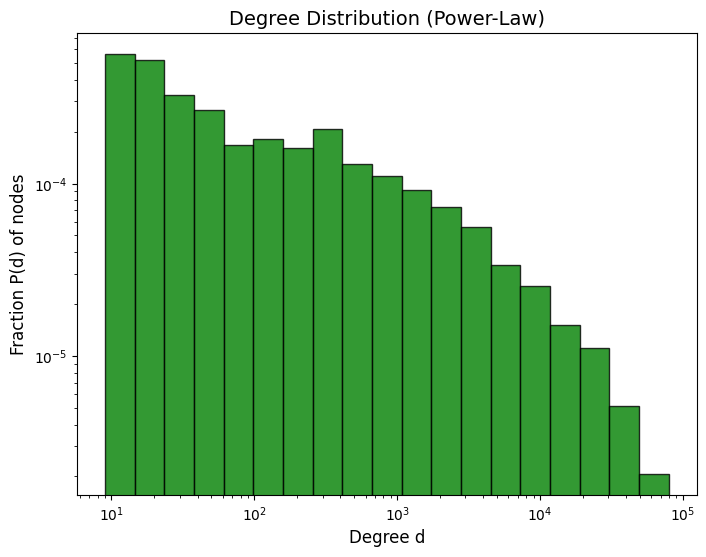

In [77]:

degrees = np.array([d for _, d in GM.degree()])

# 3️⃣ Creiamo i bins logaritmici per l'istogramma
bins = np.logspace(np.log10(degrees.min() + 1), np.log10(degrees.max()), num=20)

# 4️⃣ Calcoliamo l'istogramma normalizzato (probabilità P(d))
hist, bin_edges = np.histogram(degrees, bins=bins, density=True)

# 5️⃣ Centri dei bin per il plot
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 6️⃣ Plottiamo l'istogramma in log-log
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, hist, width=np.diff(bin_edges), color='green', edgecolor='black', alpha=0.8)

# 7️⃣ Scatter sopra l'istogramma (punti rossi)
#plt.scatter(bin_centers, hist, color='red', s=10, alpha=0.8)

# 8️⃣ Settaggi per scala log-log
plt.xscale("log")
plt.yscale("log")

plt.gca().yaxis.set_major_formatter(LogFormatterMathtext())

# 9️⃣ Etichette e titolo
plt.xlabel("Degree d", fontsize=12)
plt.ylabel("Fraction P(d) of nodes", fontsize=12)
plt.title("Degree Distribution (Power-Law)", fontsize=14)
plt.grid(False)

plt.show()

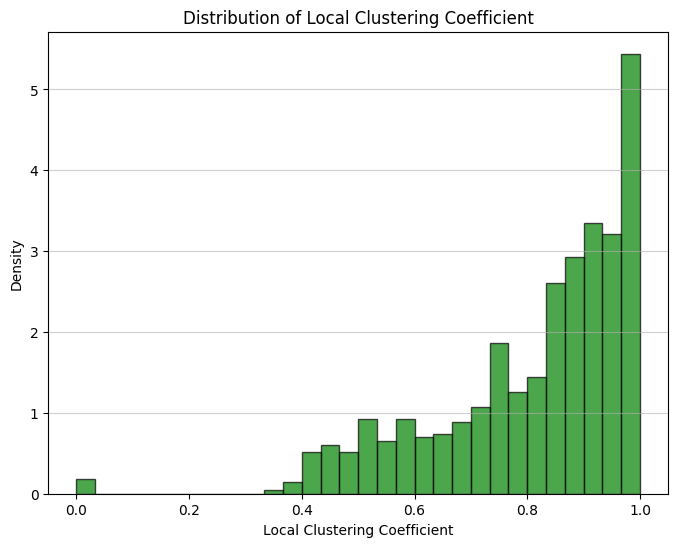

In [59]:
# 2️⃣ Calcolare il clustering coefficient per ogni nodo
clustering_coeffs = list(nx.clustering(G).values())

# 3️⃣ Plottare la distribuzione del clustering coefficient
plt.figure(figsize=(8, 6))
plt.hist(clustering_coeffs, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')

# 4️⃣ Migliorare il grafico
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Density")
plt.title("Distribution of Local Clustering Coefficient")
plt.grid(axis="y", linestyle="-", alpha=0.6)
plt.show()

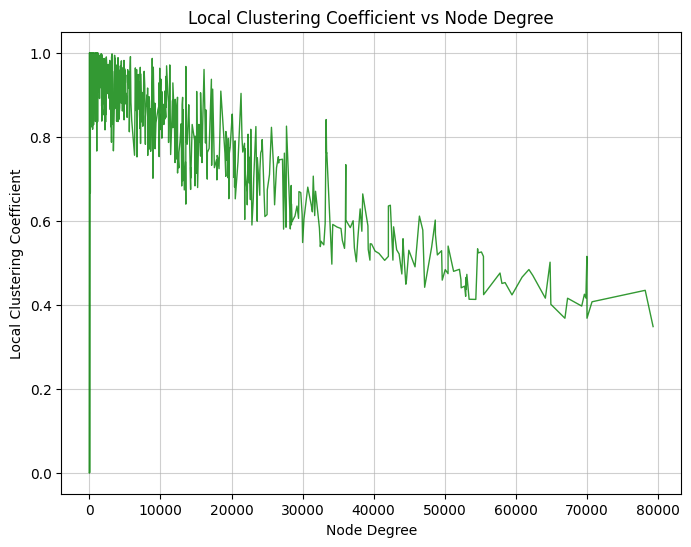

In [66]:
degrees_for_lce = dict(GM.degree())

# 4️⃣ Creiamo i dati per il plot
x = np.array(list(degrees_for_lce.values()))  # Grado dei nodi
y = np.array(clustering_coeffs)  # Clustering coefficient dei nodi

sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# 5️⃣ Plottiamo una linea continua
plt.figure(figsize=(8, 6))
plt.plot(x_sorted, y_sorted, alpha=0.8, color="green", linestyle="-", linewidth=1)

# 6️⃣ Miglioriamo la visualizzazione
plt.xlabel("Node Degree")
plt.ylabel("Local Clustering Coefficient")
plt.title("Local Clustering Coefficient vs Node Degree")
plt.grid(True, linestyle="-", alpha=0.6)

plt.show()

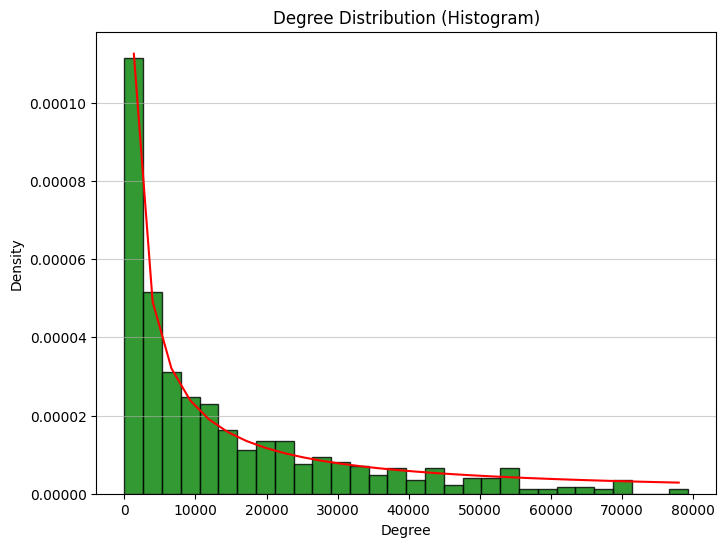

In [61]:
degrees = np.array([d for _, d in GM.degree()])
degrees = degrees[degrees > 0]
degrees.sort()

def lognormal(x, sigma, c):
    return c * np.exp(- (np.log(x) ** 2) / (2 * sigma ** 2))

hist_y, bin_edges = np.histogram(degrees, bins=30, density=True)
bin_x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Prendere il centro dei bin
popt_lognormal, _ = curve_fit(lognormal, bin_x, hist_y, p0=(1, 1))


# 3️⃣ Plottare l'istogramma della distribuzione dei gradi
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=30, density=True, alpha=0.8, color='green', edgecolor='black')
plt.plot(bin_x, lognormal(bin_x, *popt_lognormal), label="Lognormal Fit", color="red", linestyle="-")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.title("Degree Distribution (Histogram)")
plt.grid(axis="y", linestyle="-", alpha=0.6)
plt.show()

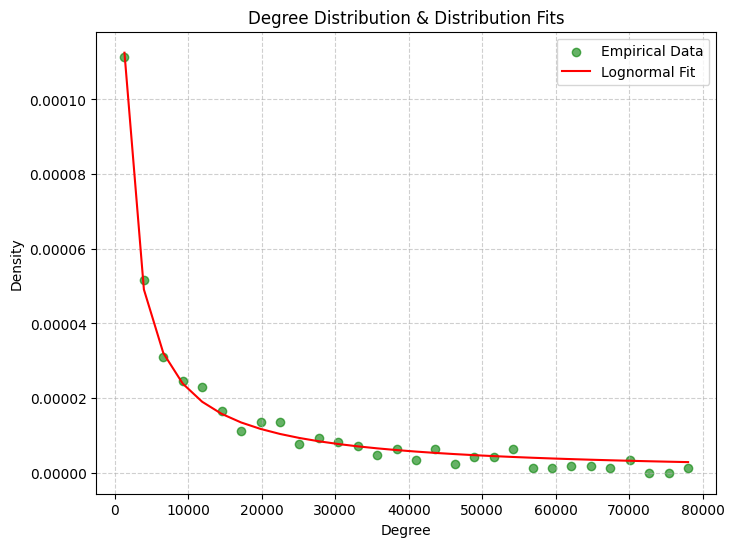

Lognormal sigma: 3.1961


In [62]:
def lognormal(x, sigma, c):
    return c * np.exp(- (np.log(x) ** 2) / (2 * sigma ** 2))

# Rimuoviamo i gradi zero e ordiniamo i dati
degrees = degrees[degrees > 0]
degrees.sort()

# Generiamo i dati empirici per il fit
hist_y, bin_edges = np.histogram(degrees, bins=30, density=True)
bin_x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Prendere il centro dei bin

# Fit delle distribuzioni
popt_lognormal, _ = curve_fit(lognormal, bin_x, hist_y, p0=(1, 1))

# Plot della distribuzione con le funzioni fitted
plt.figure(figsize=(8, 6))
plt.scatter(bin_x, hist_y, label="Empirical Data", color="green", alpha=0.6)
plt.plot(bin_x, lognormal(bin_x, *popt_lognormal), label="Lognormal Fit", color="red", linestyle="-")

# Migliorare il grafico
plt.xlabel("Degree")
plt.ylabel("Density")
plt.title("Degree Distribution & Distribution Fits")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()

# Stampiamo i parametri stimati
print(f"Lognormal sigma: {popt_lognormal[0]:.4f}")

In [ ]:
degree_centrality = dict(G.degree)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

In [19]:
for cid, score in sorted_degree_centrality[:5]:
    print(cid, score)

CID000004594 599
CID000001983 578
CID000000853 576
CID000003883 552
CID000005039 549


In [4]:
merged_se_df = pd.read_csv("./merged_side_effect.csv")

In [21]:
GMP = nx.MultiGraph()

for _, row in merged_se_df.iterrows():
    GMP.add_edge(row['# STITCH 1'], row['STITCH 2'], 
               polypharmacy_side_effect=row['Polypharmacy Side Effect'], 
               side_effect_name=row['Side Effect Name'],
               perceived_fear_score = row['Perceived fear score'])

In [35]:
closeness_centr = nx.closeness_centrality(G)
top_10_closeness_centr = heapq.nsmallest(10, closeness_centr.items(), key=lambda x:x[1])

In [24]:
average_weighted_degrees = {}

for node in GMP.nodes:
    edges = list(GMP.edges(node, keys=True, data=True))

    weighted_degree = sum(
        data.get("perceived_fear_score", 0) for _, _, _, data in edges
    )
    
    average_weighted_degree = weighted_degree / len(edges)


    average_weighted_degrees[node] = average_weighted_degree


sorted_average_weighted_degrees = sorted(
    average_weighted_degrees.items(), key=lambda x: x[1], reverse=True
)

for cid, score in sorted_average_weighted_degrees[:10]:
    print(f"{cid} & {cid_to_name(cid)} & {score}")

CID000145068 & Nitric Oxide & 0.5192658859389544
CID000004675 & [17-acetyloxy-10,13-dimethyl-2,16-bis(1-methylpiperidin-1-ium-1-yl)-2,3,4,5,6,7,8,9,11,12,14,15,16,17-tetradecahydro-1H-cyclopenta[a]phenanthren-3-yl] acetate & 0.5051913038387874
CID000036339 & Ethyl 1-(1-phenylethyl)-1H-imidazole-5-carboxylate & 0.5051303354118765
CID000036811 & Dobutamine & 0.49290672432451366
CID000002232 & 1-[2-[(3-Methyl-1,2,3,4-tetrahydroquinoline-8-yl)sulfonylamino]-5-guanidinopentanoyl]-4-methylpiperidine-2-carboxylic acid & 0.4828852222989258
CID005282044 &  & 0.48103673694316185
CID000005486 & 2-(Butylsulfonylamino)-3-[4-(4-piperidin-4-ylbutoxy)phenyl]propanoic acid & 0.4791206480336795
CID000041693 & Sufentanil & 0.47904326439043643
CID000004993 & Pyrimethamine & 0.47814041925940276
CID000003562 & Halothane & 0.4773835746438655


In [36]:
top_10_cc_list = []
for code, closeness_centr in top_10_closeness_centr:
    values_se = [data.get("side_effect_name") for _,_,data in GM.edges(code, data=True)]
    pfs_list = []
    for name in values_se:
        fear_score = side_effects_weighted_df.loc[
                    side_effects_weighted_df["Side effect"] == name, "Perceived fear score"
                ].values        
        pfs_list.append(fear_score)
    weighted_degree = sum(pfs_list)
    average_weighted_degree = weighted_degree / len(values_se)
    top_10_cc_list.append([code, cid_to_name(code), closeness_centr, float(average_weighted_degree[0])])

In [37]:
print(top_10_cc_list)

[['CID000001134', '1-[4-Hydroxy-5-(hydroxymethyl)oxolan-2-yl]-5-methylpyrimidine-2,4-dione', 0.39316239316239315, 0.4012635385020639], ['CID000004011', 'Maprotiline', 0.4250825082508251, 0.32473024473853573], ['CID000002177', '{3-[(4-Amino-benzenesulfonyl)-isobutyl-amino]-1-benzyl-2-hydroxy-propyl}-carbamic acid tetrahydro-furan-3-YL ester', 0.45224719101123595, 0.40996747988178567], ['CID000003562', 'Halothane', 0.4544812985179958, 0.4773835746438655], ['CID000051634', 'Miglustat', 0.45673758865248226, 0.4001497488449113], ['CID000005052', 'Isoreserpin', 0.4593437945791726, 0.406938627197314], ['CID000003291', 'Ethosuximide', 0.46131805157593125, 0.4490925032772308], ['CID000039860', '1-hydroxy-6,6-dimethyl-3-(2-methyloctan-2-yl)-7,8,10,10a-tetrahydro-6aH-benzo[c]chromen-9-one', 0.4633093525179856, 0.39328818539336863], ['CID003086258', '3-[18-(2-Carboxyethyl)-8-ethyl-13-(1-hydroxyethyl)-3,7,12,17-tetramethyl-22,23-dihydroporphyrin-2-yl]propanoic acid', 0.46599131693198265, 0.40924076

In [38]:
top_10_cc_df_lowest = pd.DataFrame(top_10_cc_list, columns=['CID','Drug name', 'Closeness centrality', 'Average weighted degree'])

In [39]:
print(top_10_cc_df_lowest)

            CID                                          Drug name  \
0  CID000001134  1-[4-Hydroxy-5-(hydroxymethyl)oxolan-2-yl]-5-m...   
1  CID000004011                                        Maprotiline   
2  CID000002177  {3-[(4-Amino-benzenesulfonyl)-isobutyl-amino]-...   
3  CID000003562                                          Halothane   
4  CID000051634                                          Miglustat   
5  CID000005052                                        Isoreserpin   
6  CID000003291                                       Ethosuximide   
7  CID000039860  1-hydroxy-6,6-dimethyl-3-(2-methyloctan-2-yl)-...   
8  CID003086258  3-[18-(2-Carboxyethyl)-8-ethyl-13-(1-hydroxyet...   
9  CID000002170                                          Amoxapine   

   Closeness centrality  Average weighted degree  
0              0.393162                 0.401264  
1              0.425083                 0.324730  
2              0.452247                 0.409967  
3              0.454481  

In [ ]:
#these are the highest degree centralities

            CID      Drug name  Closeness centrality  Average weighted degree
0  CID000004594     Omeprazole              0.934688                 0.413533
1  CID000001983  Acetaminophen              0.907042                 0.434233
2  CID000000853   DL-Thyroxine              0.904494                 0.414099
3  CID000003883   Lansoprazole              0.875000                 0.413170
4  CID000005039     Ranitidine              0.871448                 0.409448
5  CID000003958      Lorazepam              0.865591                 0.424040
6  CID000054454    Simvastatin              0.857523                 0.420583
7  CID000004679   Pantoprazole              0.857523                 0.419212
8  CID000005732       Zolpidem              0.857523                 0.416859
9  CID000002771     Citalopram              0.856383                 0.414014


In [5]:
top_10_drugs = ['CID000145068', 'CID000004675', 'CID000036339', 'CID000036811', 'CID000002232',
                'CID005282044', 'CID000005486', 'CID000041693', 'CID000004993', 'CID000003562']

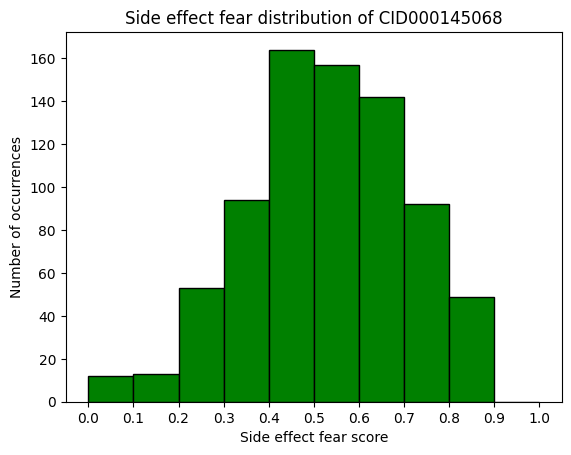

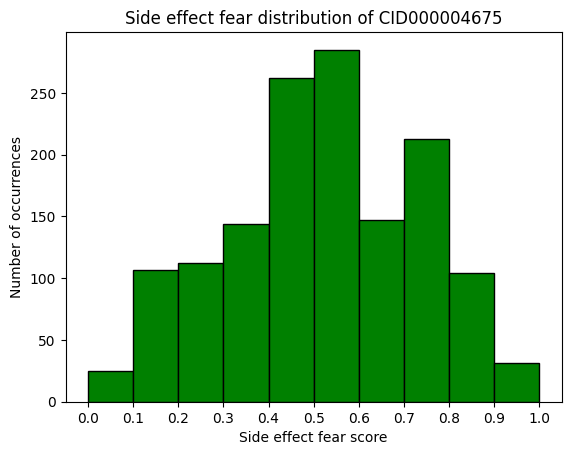

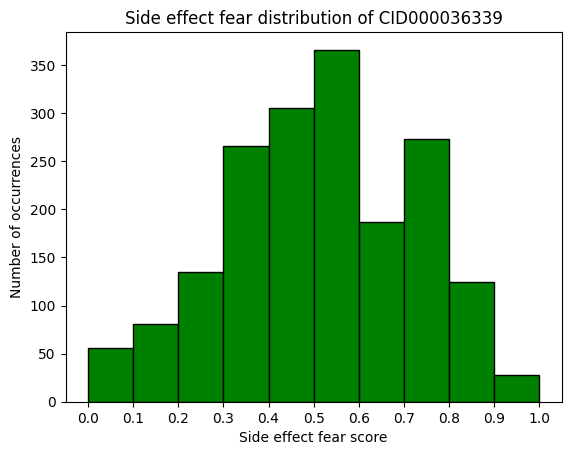

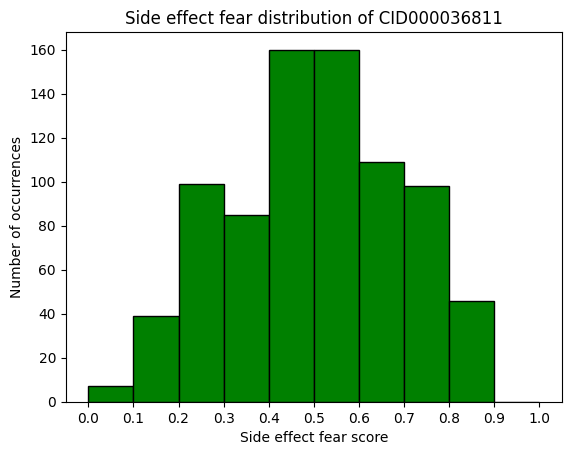

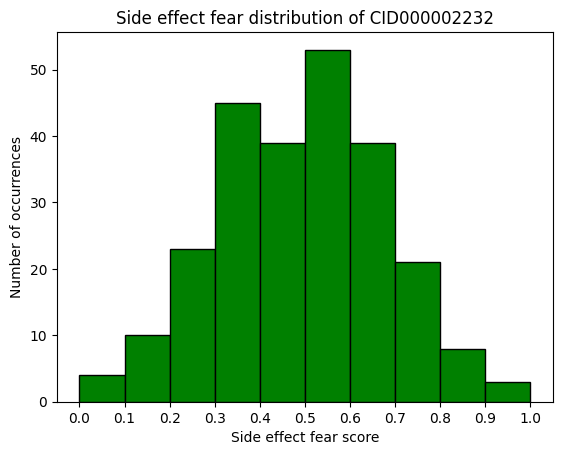

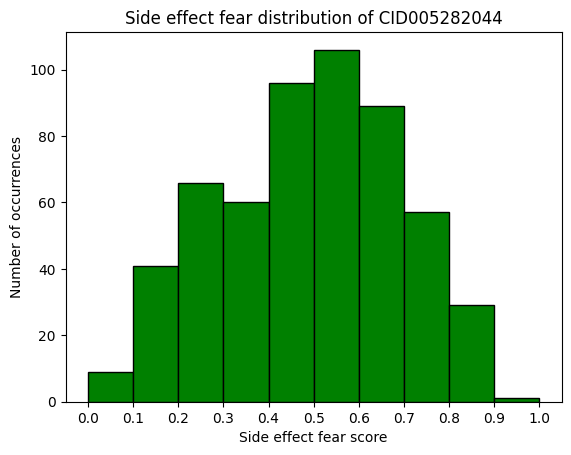

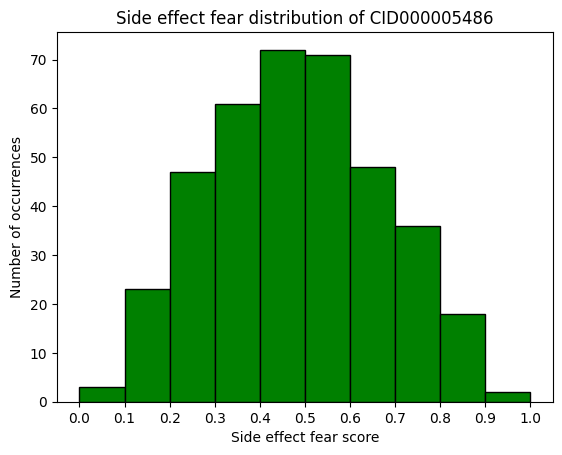

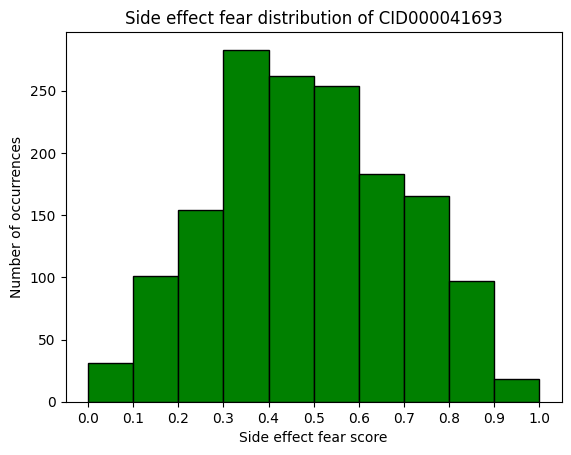

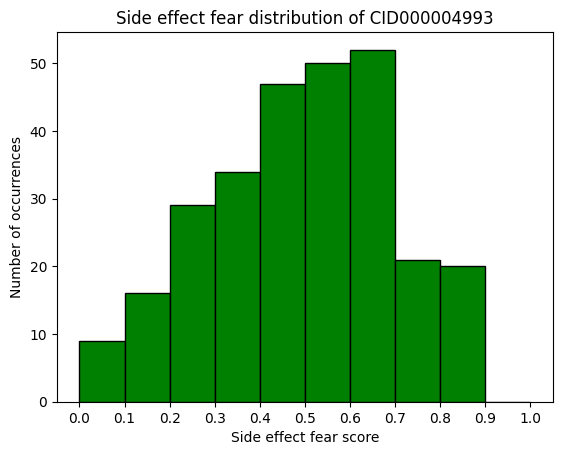

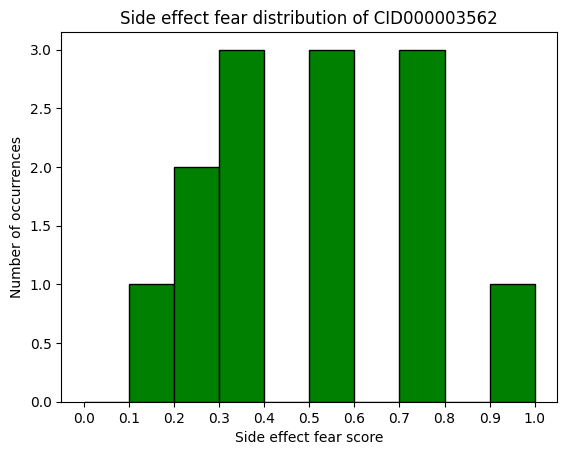

In [ ]:
for drug in top_10_drugs:
    values_se = [data.get("side_effect_name") for _,_,data in GM.edges(drug, data=True)]
    count = Counter(values_se)
    fear_score_dic = {}
    for name, count in count.items():
        fear_score = side_effects_weighted_df["Perceived fear score"][side_effects_weighted_df["Side effect"]==name]
        fear_score_dic[fear_score.iloc[0]] = count
    ordered_pfs = sorted(fear_score_dic.keys())
    ordered_counts = [fear_score_dic[k] for k in ordered_pfs]

    num_bins = 10  
    bin_edges = np.arange(0.0, 1.1, 0.1) 
    bin_indices = np.digitize(ordered_pfs, bin_edges, right=True)

    # Creiamo un dizionario per sommare i conteggi nei bin
    binned_counts = {i: 0 for i in range(1, len(bin_edges))}  # Inizializza bin vuoti

    # Sommiamo le occorrenze di ordered_counts nei bin corretti
    for value, count, bin_idx in zip(ordered_pfs, ordered_counts, bin_indices):
        if bin_idx in binned_counts:
            binned_counts[bin_idx] += count

    # Convertiamo in liste ordinate per il plot
    bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
    counts = [binned_counts[i] for i in range(1, len(bin_edges))]

    # Plot dell'istogramma raggruppato
    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), color='green', edgecolor="black")

    plt.xlabel('Side effect fear score')
    plt.ylabel('Number of occurrences')
    plt.xticks(bin_edges, labels=[f"{x:.1f}" for x in bin_edges])
    plt.title(f'Side effect fear distribution of {drug}')
    plt.show()